# Assignment 2

In [15]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

#added by me
import torchvision
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
import unicodedata
from IPython import display
import time
import xml.etree.ElementTree as ET
#end of added by me

%matplotlib inline
plt.ion()
# Import other modules if required

resnet_input = 224 #size of resnet18 input images
use_gpu = True
num_of_classes = 21

In [16]:
# Choose your hyper-parameters using validation data
batch_size = 2
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [17]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [18]:
#def build_dataset():
    # Begin

In [19]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.root_dir = root_dir
        self.train = train
        self.transform  = transform
        self.map = list()
        
        if(train == True):
            rd = root_dir + "/VOCdevkit_train/VOC2007/JPEGImages"
            rd_annot = root_dir + "/VOCdevkit_train/VOC2007/Annotations"
            
        else:
            rd = root_dir + "/VOCdevkit_test/VOC2007/JPEGImages"
            rd_annot = root_dir + "/VOCdevkit_test/VOC2007/Annotations"
        
        #count =0;
        class_count = np.zeros(num_of_classes)
        for subdir, dirs, files in os.walk(rd):
            for File in files:
                xmlFile = File.split('.')[0] + '.xml'
                xmlFileDest = rd_annot + '/' + xmlFile
                tree = ET.parse(xmlFileDest)
                root = tree.getroot()
                for obj in root.iter('object'):
                    objclass = obj.find('name').text
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    self.map = self.map + [(File, (xmin, ymin, xmax, ymax), objclass)] #objclass is a string name of class.
                    class_count[classes.index(objclass)]+=1
        print("num of examples per class:")
        print(classes)
        print(class_count)
                #if(count < 10):
                #    print(rd, subdir, File, xmlFile, xmlFileDest)
                #    print(self.map[count])
                #count+=1
                #lab = list(subdir)[-1]                
                #self.map = self.map + [(File,ord(lab)-ord('A'))]
        
    def __len__(self):
        # Begin
        return len(self.map)
        
    def __getitem__(self, idx):
       # Begin
        if(self.train == True):
            rd = self.root_dir + "/VOCdevkit_train/VOC2007/JPEGImages"
            rd_annot = self.root_dir + "/VOCdevkit_train/VOC2007/Annotations"
        else:
            rd = self.root_dir + "/VOCdevkit_test/VOC2007/JPEGImages"
            rd_annot = self.root_dir + "/VOCdevkit_test/VOC2007/Annotations"
            
        img = Image.open(rd + '/' + self.map[idx][0])
        #print(rd + '/' + self.map[idx][0])
        #print(img)
        area = self.map[idx][1] #(xmin, ymin, xmax, ymax)
        #print("area is")
        #print(area)
        img = img.crop(area)  #taking only the part specified by the (xmin, ymin, xmax, ymax)
        #print("img is:")
        #print(img)
        #print(img.format, img.size, img.mode)
        if self.transform is not None:
            im = self.transform(img)
        #print("im is")
        #print(im)
        #print(im.format, im.size, im.mode)
        classid = classes.index(self.map[idx][2])  #map the string name to id.
        return (im, classid)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [20]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.ToTensor() ])
#transforms.RandomHorizontalFlip() was removed by me from above.
train_dataset = voc_dataset(root_dir='.', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir='.', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#print(test_loader[0])

num of examples per class:
(u'__background__', u'aeroplane', u'bicycle', u'bird', u'boat', u'bottle', u'bus', u'car', u'cat', u'chair', u'cow', u'diningtable', u'dog', u'horse', u'motorbike', u'person', u'pottedplant', u'sheep', u'sofa', u'train', u'tvmonitor')
[    0.   331.   418.   599.   398.   634.   272.  1644.   389.  1432.
   356.   310.   538.   406.   390.  5447.   625.   353.   425.   328.
   367.]
num of examples per class:
(u'__background__', u'aeroplane', u'bicycle', u'bird', u'boat', u'bottle', u'bus', u'car', u'cat', u'chair', u'cow', u'diningtable', u'dog', u'horse', u'motorbike', u'person', u'pottedplant', u'sheep', u'sofa', u'train', u'tvmonitor')
[    0.   311.   389.   576.   393.   657.   254.  1541.   370.  1374.
   329.   299.   530.   395.   369.  5227.   592.   311.   396.   302.
   361.]


### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [21]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
if(torch.cuda.is_available() and use_gpu):
    resnet18.cuda()

In [22]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [23]:
def train():
    # Begin
    x = list()
    y = list()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0: 
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
                x.append((epoch*len(train_dataset))/batch_size + 1+i)
                y.append(loss.data[0])
                plt.plot(x,y,color = 'red')
                plt.title('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
                plt.xlabel("Batch Number")
                plt.ylabel("Cross Entropy Loss")
                display.clear_output(wait=True)
                display.display(plt.gcf())
            if i == 400:
                break
        break    #to run just 1 epoch
    plt.savefig('Loss_1.png')

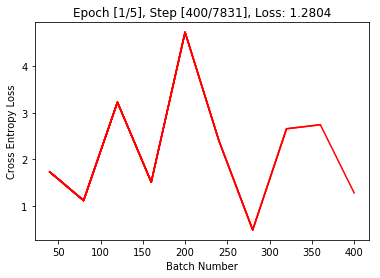

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7F05C04EA0D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7F05C04EA0D0>
CPU times: user 1min 21s, sys: 21.2 s, total: 1min 42s
Wall time: 1min 43s


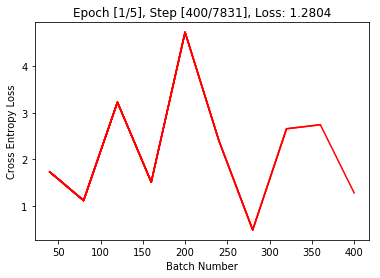

In [24]:
%time train()

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [ ]:
def sliding_window():
    
    # Begin
    res = [(40,80),(80,40),(56,56)]
    stride = 5
    for image in images:
        for i in range(3):
            for w,h in res:
                tx = w*(2**i)
                ty = h*(2**i)
                cx = 0
                cy = 0
                while(cx + tx<= image.size[1] and cy + ty <=image.size[2]):
                    cimage = cimage + [image.crop((cx, cy, cx + tx, cy + ty))]
            

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def non_maximum_supression(boxes,threshold = 0.3):
    # 
    # if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > threshold)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

Test the trained model on the test dataset.

In [ ]:
def test():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()

In [ ]:
%time test(resnet18)